# Project: Metadata Suggesties voor Online Lesmateriaal

##1. Inleiding
In dit ptoject dat we gaan uitvoeren voor de organisatie Wikiwijs is ons doel om metdatasuggesties voor het online lesmateriaal van Wikiwijs te gaan maken. We willen dat ons model uiteindelijk accurate metadata suggesties gaat geven voor het leerjaar, het niveau en het vak.

## 2. Gegevens Onderzoeken en Begrijpen

In deze sectie verkennen we de structuur van onze dataset. We richten ons op JSON-bestanden die lesmateriaal bevatten, specifiek op het bestand vmbo1.json in de submap 'Bio'.

In [1]:
import os
import json
import pandas as pd
# Specificeer het pad naar de submap 'Bio' waar 'vmbo1.json' zich bevindt
directory_path = 'C:\\Users\\jesse\\Downloads\\s\\json_files'

# Bestandsnaam van het voorbeeld JSON-bestand
file_name = '13.json'
file_path = os.path.join(directory_path, file_name)

# Lees het JSON-bestand en print de inhoud om de structuur te begrijpen
try:
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
        print(json.dumps(data, indent=4))  # Print de inhoud met een nette indeling
except Exception as e:
    print(f"Error bij het lezen van bestand {file_name}: {e}")


{
    "documentAuthors": [
        "Marjolein Kalter"
    ],
    "uuid": null,
    "authors": [
        {
            "fullName": "Marjolein Kalter",
            "referenceName": null,
            "reference": {
                "value": "6"
            },
            "firstName": "Marjolein",
            "infix": "",
            "lastName": "Kalter",
            "emailAddress": "marjolein@anderszins.com",
            "type": "author"
        }
    ],
    "documentDate": "2010-02-08T15:52:23Z",
    "bulkId": "bulk-17041135-refresh_all",
    "identifier": 13,
    "title": "Vormgeven van je arrangement",
    "description": "Instructie hoe de vormgeving van een arrangement aan te passen is",
    "lastModifiedDate": "2010-02-08T15:52:23+01:00",
    "dateCreated": "2009-10-27T17:09:40+01:00",
    "published": true,
    "publisher": null,
    "team": {
        "reference": {
            "value": "wikiwijs_maken_authors"
        },
        "name": "Wikiwijs Maken Auteurs",
        "members": [

**Analyse van vmbo1.json Inhoud**
De JSON-data van vmbo1.json biedt een diepgaand inzicht in het structuur en inhoud van het online lesmateriaal voor het thema "Omgeving" voor vmbo-b12. Hieronder volgt een gedetailleerde analyse van de sleutelcomponenten binnen het bestand:

**Metadata en Auteursinformatie**
Document Auteurs: Het document bevat namen van diverse auteurs, waaronder Pieter Bruring en Sophia Kambakhsh, die bijdragen hebben geleverd aan de inhoud
.

Publicatiedatum: De inhoud is laatst gewijzigd op 25 mei 2023, wat aangeeft dat het materiaal recent is bijgewerkt.


Licentie: Het materiaal valt onder de "CC Naamsvermelding-GelijkDelen 4.0 Internationale licentie", wat betekent dat gebruikers het werk mogen kopiëren, verspreiden, doorgeven, en afgeleide werken mogen maken onder bepaalde voorwaarden.


**Inhoud en Structuur**
Titel: "Thema Omgeving vmbo-b12" geeft duidelijk het onderwerp en het doelpubliek van het lesmateriaal aan.


Beschrijving: Er is een korte inleiding die het thema en de kernonderwerpen beschrijft, zoals levenskenmerken en voedselketens.


Secties: Het document is opgedeeld in verschillende secties, zoals "Intro", "Wat kan ik straks?", en "Wat ga ik doen?", die elk specifieke leerdoelen en activiteiten bevatten. Dit wijst op een gestructureerde benadering om de leerinhoud te presenteren.


**Educatieve Componenten**
Leerdoelen: Voor elke sectie worden specifieke leerdoelen vermeld, zoals het kunnen noemen van negen levenskenmerken en het beschrijven van de begrippen voedselketen en voedselweb.


Opdrachten: Er zijn diverse opdrachten opgenomen met duidelijke instructies en verwachte leeruitkomsten, wat bijdraagt aan een interactieve leerervaring.


Multimedia-inhoud: Het gebruik van afbeeldingen en ingesloten video's verrijkt de tekstuele inhoud en biedt een meer boeiende leerervaring.


**Reflectie en Evaluatie**
Diagnostische toets: Aan het eind van het thema is er een diagnostische toets om de kennis van de leerlingen te evalueren, wat essentieel is voor het beoordelen van het begrip van de leerstof.


Terugkijken: Er is een sectie gewijd aan zelfreflectie, waar leerlingen worden aangemoedigd om na te denken over wat ze hebben geleerd en hoe het proces is verlopen.


**Conclusie**
De inhoud van vmbo1.json toont een goed doordacht en uitgebreid lesmateriaal dat zorgvuldig is ontworpen om vmbo-b12 leerlingen te onderwijzen over het thema "Omgeving". De combinatie van gestructureerde informatie, duidelijke leerdoelen, interactieve opdrachten, en multimedia-inhoud maakt dit een waardevolle bron voor zowel leerlingen als docenten.

##2. Bouw een Input Datapipeline voor Tekst-Preprocessing

We gebruiken BeautifulSoup om HTML-content te verwijderen en reguliere expressies (re) om overbodige spaties te verwijderen. Vervolgens extraheren we de tekst uit elke sectie van onze JSON-bestanden.


In [2]:
from bs4 import BeautifulSoup
import re

def clean_html(raw_html):
    """Functie om HTML-content te verwerken en overbodige spaties te verwijderen."""
    soup = BeautifulSoup(raw_html, "html.parser")
    text = soup.get_text(separator=' ')
    text = re.sub('\s+', ' ', text).strip()
    return text

def extract_text_from_section(section):
    """Functie om inhoud uit secties te halen, inclusief subsecties."""
    text = section.get('heading', {}).get('content', '') + " "
    for item in section.get('items', []):
        text += item.get('content', '') + " "
    for subsection in section.get('sections', []):
        text += extract_text_from_section(subsection)
    return text


Nu we onze functies voor het schoonmaken en extraheren van tekst hebben, kunnen we deze toepassen op onze dataset. We lezen elk JSON-bestand uit onze dataset, extraheren de tekst met behulp van onze functies, en slaan de schone teksten op voor verdere verwerking.




In [3]:
import os
import json

# Map waarin alle vakmappen zijn opgeslagen
directory_path = 'C:\\Users\\jesse\\Downloads\\s\\json_files'

# Lijst om alle geëxtraheerde teksten op te slaan
all_texts = []

# Itereren over alle submappen (vakmappen)
for subdir in os.listdir(directory_path):
    subdirectory_path = os.path.join(directory_path, subdir)
    if os.path.isdir(subdirectory_path):
        for filename in os.listdir(subdirectory_path):
            if filename.endswith('.json'):
                file_path = os.path.join(subdirectory_path, filename)
                try:
                    with open(file_path, 'r', encoding='utf-8') as file:
                        data = json.load(file)
                    processed_text = clean_html(extract_text_from_section(data))
                    all_texts.append(processed_text)
                except Exception as e:
                    print(f"Fout bij het verwerken van bestand {filename}: {e}")

# Weergeven van de geëxtraheerde teksten
print(all_texts)


[]


Met deze pipeline voor tekst-preprocessing hebben we nu een schone, gestructureerde tekstinput die kan worden gebruikt voor verdere verwerking, zoals feature extractie of direct in een machine learning model. doordat deze functie iterateert over alle submappen zullen de lessen voor elk vak worden meegenomen.

In [4]:
def compare_texts(raw_html):
    """Functie om de originele en opgeschoonde tekst naast elkaar te tonen."""
    print("Originele Tekst:")
    print(raw_html)
    print("\nOpgeschoonde Tekst:")
    cleaned_text = clean_html(raw_html)
    print(cleaned_text)

# Voorbeeld HTML-tekst
raw_html_example = "<div>Dit is een <b>voorbeeld</b> tekst met <a href='https://example.com'>een link</a> en wat andere <i>HTML</i> elementen.<br />En een nieuwe regel.</div>"

# Vergelijk de originele met de opgeschoonde tekst
compare_texts(raw_html_example)


Originele Tekst:
<div>Dit is een <b>voorbeeld</b> tekst met <a href='https://example.com'>een link</a> en wat andere <i>HTML</i> elementen.<br />En een nieuwe regel.</div>

Opgeschoonde Tekst:
Dit is een voorbeeld tekst met een link en wat andere HTML elementen. En een nieuwe regel.


In [5]:
import tensorflow as tf

# Omzetten van de lijst met opgeschoonde teksten naar een TensorFlow Dataset
texts_dataset = tf.data.Dataset.from_tensor_slices(all_texts)

# Voorbeeld om de eerste paar elementen van de dataset te bekijken
for text in texts_dataset.take(3):
    print(text.numpy())


In [6]:
import os
import json
import re
import pandas as pd
from bs4 import BeautifulSoup

class ETLPipeline:
    """
    Een klasse die een ETL-pijplijn vertegenwoordigt voor het extraheren, transformeren 
    en laden van data uit JSON-bestanden.
    """
    
    VALID_SUBJECTS = {
        "Aardrijkskunde", "Biologie", "Duits", "Economie", "Engels", "Geschiedenis", "Informatica", 
        "Nederlands", "Rekenen/wiskunde", "Natuurkunde", "Scheikunde", "M&M", "M&N", "Maatschappij"
    }
    
    def __init__(self, directory_path):
        """
        Initialiseer de ETLPipeline met een pad naar de directory met JSON-bestanden.
        
        Parameters:
        directory_path (str): Het pad naar de directory met JSON-bestanden.
        """
        self.directory_path = directory_path
        self.all_texts = []
        self.vakken = []
        self.leerjaren = []
        self.niveaus = []

    def clean_html(self, raw_html):
        """
        Maak HTML-tekst schoon door tags te verwijderen en overtollige spaties te reduceren.
        
        Parameters:
        raw_html (str): De rauwe HTML-tekst die schoongemaakt moet worden.
        
        Returns:
        str: De schoongemaakte tekst.
        """
        soup = BeautifulSoup(raw_html, "html.parser")
        text = soup.get_text(separator=' ')
        text = re.sub('\s+', ' ', text).strip()
        return text

    def extract_text_from_section(self, section):
        """
        Extraheer tekst uit een sectie van een JSON-bestand, inclusief subsecties.
        
        Parameters:
        section (dict): Een sectie van het JSON-bestand.
        
        Returns:
        str: De geëxtraheerde tekst.
        """
        text = section.get('heading', {}).get('content', '') + " "
        for item in section.get('items', []):
            text += item.get('content', '') + " "
        for subsection in section.get('sections', []):
            text += self.extract_text_from_section(subsection)
        return text

    def extract_text(self):
        """
        Doorloop de directory en verwerk alle JSON-bestanden om tekst en metadata te extraheren.
        """
        for subdir, _, files in os.walk(self.directory_path):
            for filename in files:
                if filename.endswith('.json'):
                    file_path = os.path.join(subdir, filename)
                    try:
                        with open(file_path, 'r', encoding='utf-8') as file:
                            data = json.load(file)
                        processed_text = self.clean_html(self.extract_text_from_section(data))
                        self.all_texts.append(processed_text)
                        self.extract_metadata(data)  # Metadata extraheren
                    except Exception as e:
                        print(f"Error processing file {filename}: {e}")

    def extract_metadata(self, data):
        """
        Extraheer metadata zoals vakken, leerjaren en niveaus uit de JSON-data.
        
        Parameters:
        data (dict): De JSON-data waarvan de metadata wordt geëxtraheerd.
        """
        vakken_set = set()
        leerjaren_set = set()
        niveaus_set = set()

        for term in data.get('colophon', {}).get('metadata', []):
            if not isinstance(term, dict):
                print(f"Issue with metadata entry: {term}")
                continue

            key = term.get('key')
            terms = term.get('terms')

            if key == 'disciplines':
                if terms is not None and isinstance(terms, (dict, list)):
                    if isinstance(terms, dict):
                        elements = terms.values()
                    else:
                        elements = terms
                    for element in elements:
                        if element:
                            vakken_set.update(map(lambda x: x.strip(), element.split(',')))
                else:
                    print(f"Issue with 'disciplines' metadata: {terms}")
            elif key == 'educationalLevels':
                if terms is not None and isinstance(terms, dict):
                    for value in terms.values():
                        if value:
                            leerjaren_set.update(re.findall(r'\b\d+\b', value))
                            levels = map(lambda x: x.strip(), value.split(','))
                            niveaus_set.update(levels)
                else:
                    print(f"Issue with 'educationalLevels' metadata: {terms}")

        vakken_set = vakken_set.intersection(self.VALID_SUBJECTS)
        
        self.vakken.append(', '.join(sorted(vakken_set)))
        self.leerjaren.append(', '.join(sorted(leerjaren_set, key=int)))
        self.niveaus.append(', '.join(sorted(niveaus_set)))
    
    def create_dataframe(self):
        """
        Maak een Pandas DataFrame aan met de geëxtraheerde teksten en metadata.
        
        Returns:
        pd.DataFrame: Een DataFrame met kolommen voor tekst, vakken, leerjaren en niveaus.
        """
        df = pd.DataFrame({'text': self.all_texts, 
                           'vakken': self.vakken, 
                           'leerjaren': self.leerjaren, 
                           'niveaus': self.niveaus})
        return df

# Gebruik
directory_path = 'C:\\Users\\jesse\\Downloads\\s'
pipeline = ETLPipeline(directory_path)
pipeline.extract_text()
dataframe = pipeline.create_dataframe()

print(dataframe.head())


C:\Users\jesse\AppData\Local\Temp\ipykernel_9120\1987386950.py:41: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(raw_html, "html.parser")


                                                text vakken  \
0  Inleiding Namibië, officieel de Republiek Nami...          
1  Lesideeën Ondertitelen informatief filmpje Zoe...          
2  Toolbox Introduction The toolbox is a kind of ...          
3  Webkwestie groep 8; Het EK in Frankrijk Wil ji...          
4  De organisatie Bedrijfsprofiel Het Da Vinci Co...          

                leerjaren                                            niveaus  
0                                                                             
1                       1                                              VWO 1  
2                                                                             
3  1, 2, 3, 4, 5, 6, 7, 8  PO groep 1, PO groep 2, PO groep 3, PO groep 4...  
4                                                                             


In [7]:

dataframe = dataframe[dataframe['vakken'] != '']
dataframe

text            vakken  \
5      Geslachtziekten Kennisbank Bestudeer uit de Ke...          Biologie   
6      SOA Verwerking Stap7 Soa's Bekijk dit filmpje:...          Biologie   
8      Fotosynthese Intro Mensen moeten ademhalen om ...          Biologie   
9      NL transportland Vooraf Nederland is een klein...    Aardrijkskunde   
13     Hoofdstuk 3: Grenzen en identiteit Inleiding G...    Aardrijkskunde   
...                                                  ...               ...   
64382  Problemen met water Vooraf Aan een aantal wete...    Aardrijkskunde   
64384  De wereld na de oorlog 1. Het einde van de wer...      Geschiedenis   
64387  Cellen en weefsels Kennisbank Alle organismen ...          Biologie   
64396  START test Thema Grenzen en identiteit Inleidi...    Aardrijkskunde   
64402  Omtrek cirkel Introductie omtrek cirkel We gaa...  Rekenen/wiskunde   

      leerjaren                                            niveaus  
5             4  4, VMBO gemengde leerweg, VMBO kaderberoepsger...  
6             4                                             HAVO 4  
8          1, 2  1, 2, VMBO gemengde leerweg, VMBO kaderberoeps...  
9             3                                      HAVO 3, VWO 3  
13         3, 4  3, 4, VMBO gemengde leerweg, VMBO kaderberoeps...  
...         ...                                                ...  
64382      1, 2                       HAVO 1, HAVO 2, VWO 1, VWO 2  
64384         3                                             HAVO 3  
64387      3, 4            3, 4, VMBO basisberoepsgerichte leerweg  
64396      3, 4  3, 4, VMBO gemengde leerweg, VMBO kaderberoeps...  
64402         2  2, VMBO gemengde leerweg, VMBO kaderberoepsger...  

[14723 rows x 4 columns]

In [8]:
empty_vakken_rows = dataframe[dataframe['vakken'] == '']
empty_vakken_rows.head(10)



Empty DataFrame
Columns: [text, vakken, leerjaren, niveaus]
Index: []

## Kleine EDA

In [9]:
display(dataframe.head())
display(dataframe.info())

text          vakken  \
5   Geslachtziekten Kennisbank Bestudeer uit de Ke...        Biologie   
6   SOA Verwerking Stap7 Soa's Bekijk dit filmpje:...        Biologie   
8   Fotosynthese Intro Mensen moeten ademhalen om ...        Biologie   
9   NL transportland Vooraf Nederland is een klein...  Aardrijkskunde   
13  Hoofdstuk 3: Grenzen en identiteit Inleiding G...  Aardrijkskunde   

   leerjaren                                            niveaus  
5          4  4, VMBO gemengde leerweg, VMBO kaderberoepsger...  
6          4                                             HAVO 4  
8       1, 2  1, 2, VMBO gemengde leerweg, VMBO kaderberoeps...  
9          3                                      HAVO 3, VWO 3  
13      3, 4  3, 4, VMBO gemengde leerweg, VMBO kaderberoeps...

<class 'pandas.core.frame.DataFrame'>
Index: 14723 entries, 5 to 64402
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       14723 non-null  object
 1   vakken     14723 non-null  object
 2   leerjaren  14723 non-null  object
 3   niveaus    14723 non-null  object
dtypes: object(4)
memory usage: 575.1+ KB


None

In [10]:
print(dataframe.isnull().sum())


text         0
vakken       0
leerjaren    0
niveaus      0
dtype: int64


we zien dat er geen missende waardes zijn

Wij zien in deze dataframe dat er lessen zijn voor PO, met leerjaar 1-8. Wij willen alleen lessen uit het voortgezet onderwijs.

In [11]:
dataframe.drop(dataframe[dataframe['niveaus'].str.contains('PO groep') | dataframe['niveaus'].str.contains('HBO - Bachelor')].index, inplace=True)
dataframe.drop(dataframe[dataframe['niveaus'].str.contains('PO groep') | dataframe['niveaus'].str.contains('Volwasseneneducatie')].index, inplace=True)
dataframe.drop(dataframe[dataframe['niveaus'].str.contains('PO groep') | dataframe['niveaus'].str.contains('Master')].index, inplace=True)
dataframe.drop(dataframe[dataframe['niveaus'].str.contains('PO groep') | dataframe['niveaus'].str.contains('opleiding')].index, inplace=True)


Nu kunnen we deze PO content uit de dataset halen.

In [12]:
dataframe



text            vakken  \
5      Geslachtziekten Kennisbank Bestudeer uit de Ke...          Biologie   
6      SOA Verwerking Stap7 Soa's Bekijk dit filmpje:...          Biologie   
8      Fotosynthese Intro Mensen moeten ademhalen om ...          Biologie   
9      NL transportland Vooraf Nederland is een klein...    Aardrijkskunde   
13     Hoofdstuk 3: Grenzen en identiteit Inleiding G...    Aardrijkskunde   
...                                                  ...               ...   
64382  Problemen met water Vooraf Aan een aantal wete...    Aardrijkskunde   
64384  De wereld na de oorlog 1. Het einde van de wer...      Geschiedenis   
64387  Cellen en weefsels Kennisbank Alle organismen ...          Biologie   
64396  START test Thema Grenzen en identiteit Inleidi...    Aardrijkskunde   
64402  Omtrek cirkel Introductie omtrek cirkel We gaa...  Rekenen/wiskunde   

      leerjaren                                            niveaus  
5             4  4, VMBO gemengde leerweg, VMBO kaderberoepsger...  
6             4                                             HAVO 4  
8          1, 2  1, 2, VMBO gemengde leerweg, VMBO kaderberoeps...  
9             3                                      HAVO 3, VWO 3  
13         3, 4  3, 4, VMBO gemengde leerweg, VMBO kaderberoeps...  
...         ...                                                ...  
64382      1, 2                       HAVO 1, HAVO 2, VWO 1, VWO 2  
64384         3                                             HAVO 3  
64387      3, 4            3, 4, VMBO basisberoepsgerichte leerweg  
64396      3, 4  3, 4, VMBO gemengde leerweg, VMBO kaderberoeps...  
64402         2  2, VMBO gemengde leerweg, VMBO kaderberoepsger...  

[13982 rows x 4 columns]

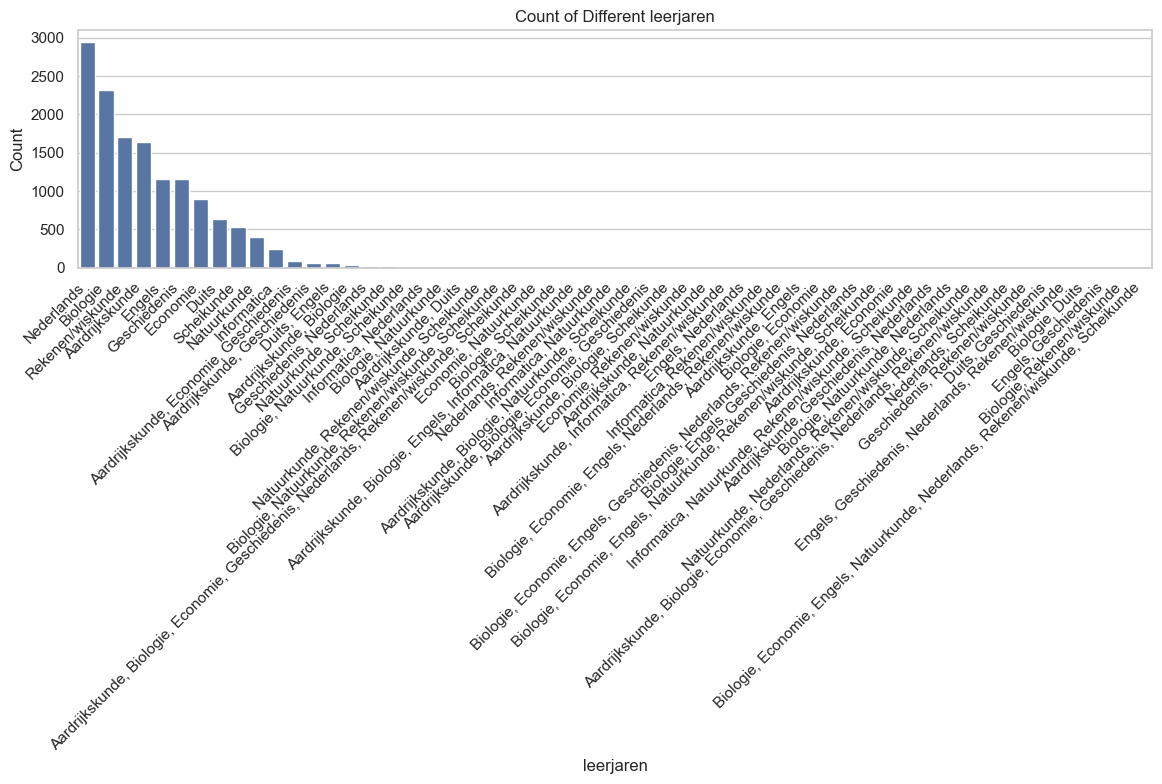

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of the plot
sns.set(style="whitegrid")

# Create the bar plot
plt.figure(figsize=(12, 8))
sns.countplot(data=dataframe, x='vakken', order=dataframe['vakken'].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.xlabel('leerjaren')
plt.ylabel('Count')
plt.title('Count of Different leerjaren')
plt.tight_layout()
plt.show()


hier zien we dat de sommige vakken samen zitten en dan moeten we niet hebben.

In [14]:
vakken_list = dataframe['vakken'].unique()
print(vakken_list)


['Biologie' 'Aardrijkskunde' 'Nederlands' 'Economie' 'Geschiedenis'
 'Scheikunde' 'Duits' 'Informatica' 'Engels' 'Rekenen/wiskunde'
 'Natuurkunde' 'Aardrijkskunde, Biologie'
 'Aardrijkskunde, Economie, Geschiedenis'
 'Natuurkunde, Rekenen/wiskunde, Scheikunde'
 'Biologie, Natuurkunde, Rekenen/wiskunde, Scheikunde'
 'Natuurkunde, Scheikunde' 'Aardrijkskunde, Duits'
 'Biologie, Rekenen/wiskunde' 'Engels, Nederlands'
 'Aardrijkskunde, Informatica, Rekenen/wiskunde' 'Biologie, Natuurkunde'
 'Aardrijkskunde, Geschiedenis' 'Economie, Rekenen/wiskunde'
 'Economie, Natuurkunde' 'Biologie, Scheikunde'
 'Biologie, Natuurkunde, Scheikunde' 'Engels, Geschiedenis'
 'Biologie, Duits' 'Aardrijkskunde, Geschiedenis, Nederlands'
 'Engels, Geschiedenis, Nederlands, Rekenen/wiskunde'
 'Aardrijkskunde, Biologie, Engels, Informatica, Natuurkunde'
 'Aardrijkskunde, Natuurkunde' 'Duits, Engels' 'Duits, Geschiedenis'
 'Geschiedenis, Nederlands' 'Geschiedenis, Rekenen/wiskunde'
 'Aardrijkskunde, Biologie, Sche

hier maken we met behulp van een fuctie een nieuwe kolom aan waar de vakken niet samen zitten.

In [15]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
valid_subjects = [

    "Aardrijkskunde", "Biologie", "Duits", "Economie", "Engels", "Geschiedenis", "Informatica", "Nederlands", "Rekenen", "Natuurkunde", "Scheikunde", "M&M", "M&N", "Maatschappij"
    
]

def clean_vakken(vakken_list, valid_subjects):
    """
    Maak een lijst van vakken schoon door alleen geldige vakken te behouden.
    
    Parameters:
    vakken_list (list): Lijst van vakkenstrings gescheiden door komma's.
    valid_subjects (list): Lijst van geldige vakken.
    
    Returns:
    list: Een lijst van schoongemaakte vakken, waarbij niet-geldige vakken worden genegeerd.
    """
    cleaned_vakken = []
    for vakken in vakken_list:
        subjects = [sub.strip() for sub in vakken.split(",")]
        found_subject = None
        for subject in subjects:
            if subject in valid_subjects:
                found_subject = subject
                break  
        if found_subject:
            cleaned_vakken.append(found_subject)
        else:
            cleaned_vakken.append(None)  
    return cleaned_vakken

# Toepassen van de functie om een nieuwe kolom in de dataframe toe te voegen
dataframe['cleaned_vakken'] = clean_vakken(dataframe['vakken'].tolist(), valid_subjects)

# Filter de dataframe om rijen met niet-geldige vakken te verwijderen
dataframe = dataframe.dropna(subset=['cleaned_vakken'])


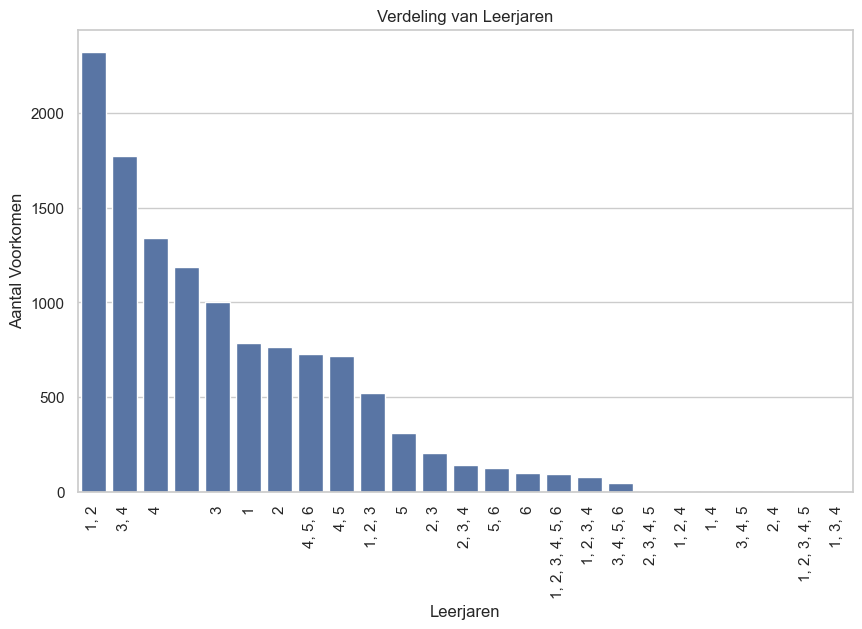

In [16]:
# Uitpakken van de leerjaren lijst en tellen
df_leerjaren = dataframe.explode('leerjaren')
leerjaar_count = df_leerjaren['leerjaren'].value_counts()

# Barplot van leerjaren
plt.figure(figsize=(10, 6))
sns.barplot(x=leerjaar_count.index, y=leerjaar_count.values)
plt.title('Verdeling van Leerjaren')
plt.xlabel('Leerjaren')
plt.ylabel('Aantal Voorkomen')
plt.xticks(rotation=90)
plt.show()

hier splitsen we de leerjaren en niveaus 

In [17]:
dataframe.loc[:, 'leerjaren_split'] = dataframe['leerjaren'].apply(lambda x: [int(y.strip()) for y in x.split(',') if y.strip()])
dataframe.loc[:, 'niveaus_split'] = dataframe['niveaus'].apply(lambda x: [y.strip() for y in x.split(',')])



C:\Users\jesse\AppData\Local\Temp\ipykernel_9120\2342299225.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.loc[:, 'leerjaren_split'] = dataframe['leerjaren'].apply(lambda x: [int(y.strip()) for y in x.split(',') if y.strip()])
C:\Users\jesse\AppData\Local\Temp\ipykernel_9120\2342299225.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe.loc[:, 'niveaus_split'] = dataframe['niveaus'].apply(lambda x: [y.strip() for y in x.split(',')])


In [18]:
dataframe

text          vakken  \
5      Geslachtziekten Kennisbank Bestudeer uit de Ke...        Biologie   
6      SOA Verwerking Stap7 Soa's Bekijk dit filmpje:...        Biologie   
8      Fotosynthese Intro Mensen moeten ademhalen om ...        Biologie   
9      NL transportland Vooraf Nederland is een klein...  Aardrijkskunde   
13     Hoofdstuk 3: Grenzen en identiteit Inleiding G...  Aardrijkskunde   
...                                                  ...             ...   
64381  Nederland waterland Vooraf In het begin van de...  Aardrijkskunde   
64382  Problemen met water Vooraf Aan een aantal wete...  Aardrijkskunde   
64384  De wereld na de oorlog 1. Het einde van de wer...    Geschiedenis   
64387  Cellen en weefsels Kennisbank Alle organismen ...        Biologie   
64396  START test Thema Grenzen en identiteit Inleidi...  Aardrijkskunde   

      leerjaren                                            niveaus  \
5             4  4, VMBO gemengde leerweg, VMBO kaderberoepsger...   
6             4                                             HAVO 4   
8          1, 2  1, 2, VMBO gemengde leerweg, VMBO kaderberoeps...   
9             3                                      HAVO 3, VWO 3   
13         3, 4  3, 4, VMBO gemengde leerweg, VMBO kaderberoeps...   
...         ...                                                ...   
64381      1, 2                       HAVO 1, HAVO 2, VWO 1, VWO 2   
64382      1, 2                       HAVO 1, HAVO 2, VWO 1, VWO 2   
64384         3                                             HAVO 3   
64387      3, 4            3, 4, VMBO basisberoepsgerichte leerweg   
64396      3, 4  3, 4, VMBO gemengde leerweg, VMBO kaderberoeps...   

       cleaned_vakken leerjaren_split  \
5            Biologie             [4]   
6            Biologie             [4]   
8            Biologie          [1, 2]   
9      Aardrijkskunde             [3]   
13     Aardrijkskunde          [3, 4]   
...               ...             ...   
64381  Aardrijkskunde          [1, 2]   
64382  Aardrijkskunde          [1, 2]   
64384    Geschiedenis             [3]   
64387        Biologie          [3, 4]   
64396  Aardrijkskunde          [3, 4]   

                                           niveaus_split  
5      [4, VMBO gemengde leerweg, VMBO kaderberoepsge...  
6                                               [HAVO 4]  
8      [1, 2, VMBO gemengde leerweg, VMBO kaderberoep...  
9                                        [HAVO 3, VWO 3]  
13     [3, 4, VMBO gemengde leerweg, VMBO kaderberoep...  
...                                                  ...  
64381                     [HAVO 1, HAVO 2, VWO 1, VWO 2]  
64382                     [HAVO 1, HAVO 2, VWO 1, VWO 2]  
64384                                           [HAVO 3]  
64387          [3, 4, VMBO basisberoepsgerichte leerweg]  
64396  [3, 4, VMBO gemengde leerweg, VMBO kaderberoep...  

[12270 rows x 7 columns]

In [19]:
dataframe['text']

5        Geslachtziekten Kennisbank Bestudeer uit de Ke...
6        SOA Verwerking Stap7 Soa's Bekijk dit filmpje:...
8        Fotosynthese Intro Mensen moeten ademhalen om ...
9        NL transportland Vooraf Nederland is een klein...
13       Hoofdstuk 3: Grenzen en identiteit Inleiding G...
                               ...                        
64381    Nederland waterland Vooraf In het begin van de...
64382    Problemen met water Vooraf Aan een aantal wete...
64384    De wereld na de oorlog 1. Het einde van de wer...
64387    Cellen en weefsels Kennisbank Alle organismen ...
64396    START test Thema Grenzen en identiteit Inleidi...
Name: text, Length: 12270, dtype: object

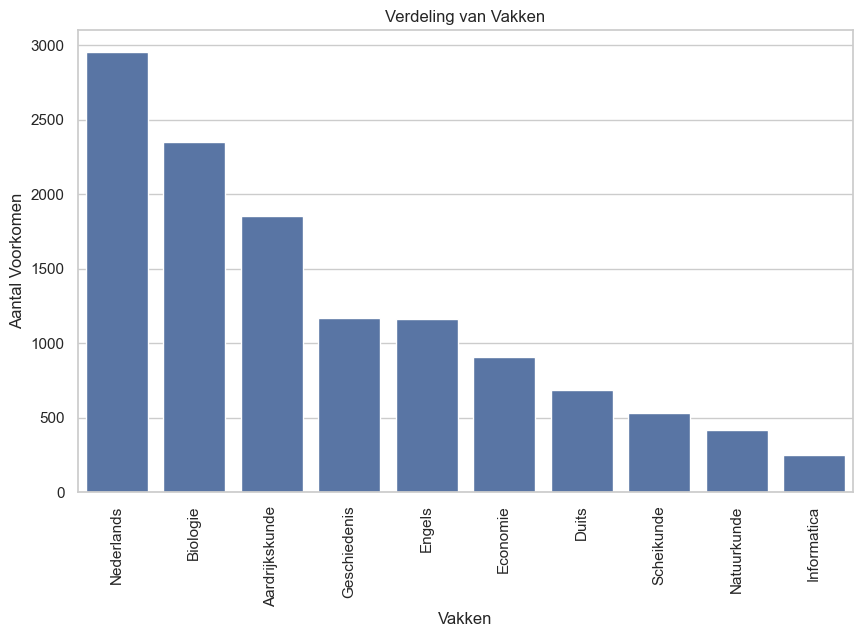

In [20]:


# Tellen van het aantal voorkomen van elk vak
vak_count = dataframe['cleaned_vakken'].value_counts()

# Barplot van vakken
plt.figure(figsize=(10, 6))
sns.barplot(x=vak_count.index, y=vak_count.values)
plt.title('Verdeling van Vakken')
plt.xlabel('Vakken')
plt.ylabel('Aantal Voorkomen')
plt.xticks(rotation=90)
plt.show()


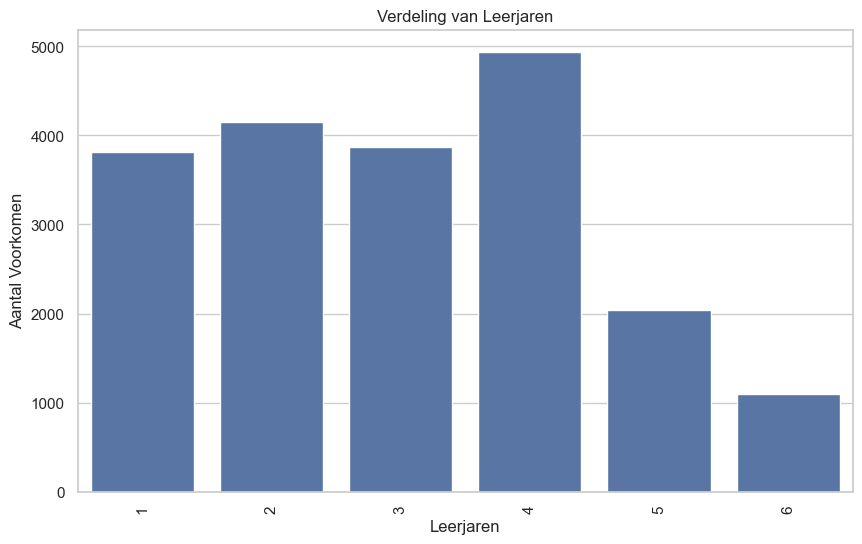

In [21]:
# Uitpakken van de leerjaren lijst en tellen
df_leerjaren = dataframe.explode('leerjaren_split')
leerjaar_count = df_leerjaren['leerjaren_split'].value_counts()

# Barplot van leerjaren
plt.figure(figsize=(10, 6))
sns.barplot(x=leerjaar_count.index, y=leerjaar_count.values)
plt.title('Verdeling van Leerjaren')
plt.xlabel('Leerjaren')
plt.ylabel('Aantal Voorkomen')
plt.xticks(rotation=90)
plt.show()


We zien dat veel jeerlaren samen zijn (1,2)

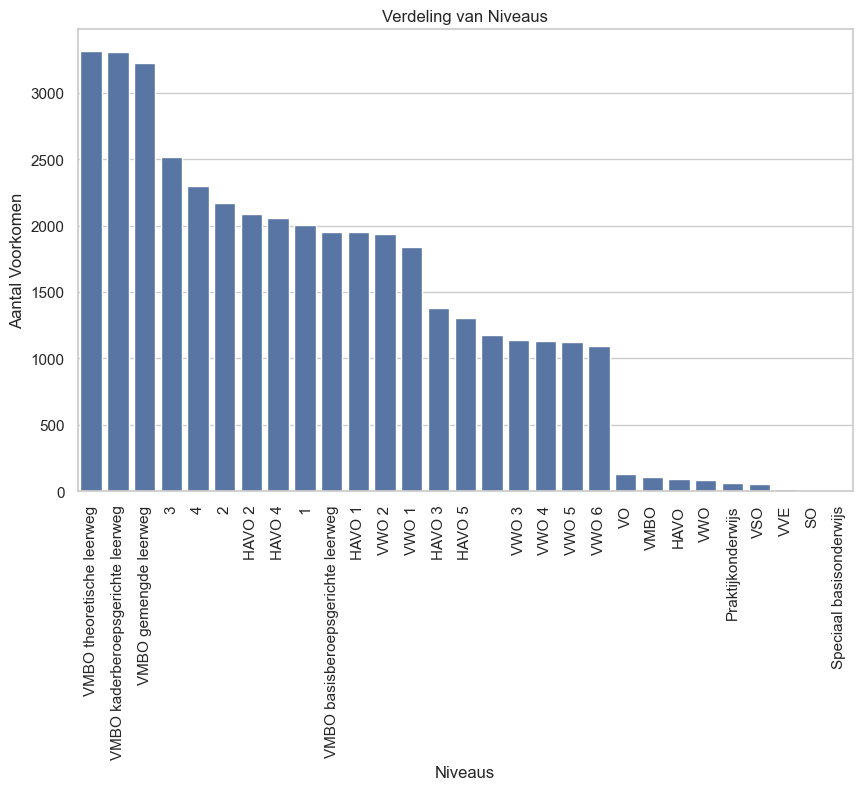

In [22]:
# Uitpakken van de niveaus lijst en tellen
df_niveaus = dataframe.explode('niveaus_split')
niveau_count = df_niveaus['niveaus_split'].value_counts()

# Barplot van niveaus
plt.figure(figsize=(10, 6))
sns.barplot(x=niveau_count.index, y=niveau_count.values)
plt.title('Verdeling van Niveaus')
plt.xlabel('Niveaus')
plt.ylabel('Aantal Voorkomen')
plt.xticks(rotation=90)
plt.show()


# Keywords van Vakken

Geen idee of we keywords nodig hebben (nog nooit mee gewerkt). ff opletten dat die niet hele tijd biologie voorspelt door die keywords

Aangezien onze traindata alleen vo-content is worden de voorspellingen ook gedaan op de vakken van vo-content. Onze data bevat ook andere vakken zoals dans, muziek, wiskunde A,B,C,D, spaans, tekenen, enzovoort. Deze komen allen uit de officiele vakken lijst, vakken.json.

Wij moeten dus bepalen of we deze keywords op basis doen van VO-content vakken of die van de officiele vakkenlijst. Accuracy gaat uiteraard omhoog wanneer we dit doen op de lijst van vo-content.

In [23]:
# basketbal
biologie_keywords = ['omgeving', 'ordenen', 'blessures', 'organismen', 'geraamte', 'beenderen', 'lichaamshouding', 'zintuigen', 'zenuwstelsel', 'ogen', 'fotosynthese', 'voortplanting', 'zaad', 'eetgewoontes', 'voedingsstoffen', 'spijsvertering', 'ademhaling', 'seksualiteit', 'menstruatie', 'erfelijkheid', 'evolutie', 'celdeling', 'milieu', 'orgaan', 'zaadplanten', 'verbranding', 'voedselweb', 'overlevingsstrategieen', 'verteren', 'verkouden', 'ademhalingsstelsel', 'impulsen', 'zenuwstelsel', 'infectie', 'hartvaten', 'bloedvaten', 'hersenen', 'geraamte', 'beenverbindingen', 'spieren', 'menstruatiecyclus', 'geslachtsziekten', 'zwangerschap', 'voorbehoedsmiddelen', 'zwangerschap', 'skelet', 'ademhaling', 'natuur', 'hygiene', 'biologie', 'biotechnologie', 'levenskenmerken', 'ecosysteem', 'voedselweb', 'voedselketen', 'diergedrag', 'beenderen', 'bestuiving', 'spijsvertering', 'gebit', 'ademhaling', 'longziekten', 'kanker', 'afweersysteem', 'bloedtransfusies', 'broeikaseffect', 'afvalvertering', 'weefsel', 'dissimilatie', 'plantenweefsels', 'bloedsomloop', 'lymfe', 'nieren', 'skelet', 'schimmel', 'hormonen', 'infectie', 'bacterie', 'biotisch', 'erfelijk', 'mitose', 'meiose', 'monohybride', 'gedragsonderzoek', 'duurzaamheid', 'milieuvervuiling', 'bestuiving', 'diergedrag', 'ademhaling', 'bloed', 'erfelijkheid', 'broeikaseffect', 'schimmels', 'verloskundige', 'ziekenhuis', 'verpleegkundige', 'hormonen', 'anabolen', 'oogarts', 'neuroloog', 'revalidatiearts', 'eukaryoot', 'geneticus', 'hartklopping', 'osmoregulatie' ]
duits_keywords = [ 'deutsche', 'sprache', 'grammatik', 'konjugation', 'verben', 'nomen', 'adjektive', 'artikel', 'zeitformen', 'perfekt', 'imperfekt', 'präteritum', 'plusquamperfekt', 'kommaregeln', 'satzbau', 'wortschatz', 'redewendungen', 'aussprache', 'lesen', 'schreiben', 'sprechen', 'hören', 'komposition', 'aufsatz', 'textanalyse', 'lyrik', 'prosa', 'drama', 'literatur', 'schriftsteller', 'dichter', 'leseverstehen', 'hörverstehen', 'dialog', 'diskussion', 'referat', 'präsentation', 'diktat', 'wortbildung', 'synonyme', 'antonyme', 'falsche freunde', 'idiomatik', 'präpositionen', 'konjunktion', 'adverbien', 'pronomen', 'modalverben', 'imperativ', 'subjunktiv', 'indikativ', 'passiv', 'aktiv', 'rechtschreibung', 'schriftliche kommunikation', 'mündliche kommunikation', 'landeskunde', 'deutschland', 'österreich', 'schweiz', 'kultur', 'geschichte', 'gesellschaft', 'politik', 'wirtschaft', 'geografie', 'tourismus', 'bräuche', 'feste', 'traditionen', 'musik', 'kunst', 'film', 'theater', 'kulinarik', 'architektur', 'epochen', 'reformation', 'aufklärung', 'romantik', 'expressionismus', 'moderne', 'postmoderne', 'vergangenheit', 'gegenwart', 'zukunft', 'medien', 'zeitungen', 'zeitschriften', 'internet', 'soziale netzwerke', 'süddeutsche zeitung', 'frankfurter allgemeine', 'spiegel', 'focus', 'tagesschau', 'deutsche welle', 'bildbeschreibung', 'erörterung', 'interpretation', 'rezension', 'buchbesprechung', 'kollokation' ]
eco_keywords = ['economie', 'uitgaven', 'budget', 'inkomstenbronnen', 'inkomensverschillen', 'budget', 'productiefactoren', 'vraag en aanbod', 'bedrijfskosten', 'marketingmix', 'koopgedrag', 'lenen', 'hypotheek', 'onderhandelen', 'verzekering', 'onderneming', 'vennootschap', 'monopolie', 'economische groei', 'arbeidsmarkt', 'break-even', 'valuta', 'werkloosheid', 'inflatie', 'warenonderzoek', 'arbeidsovereenkomst', 'minimumloon', 'werknemer', 'werkgever', 'uitgaven', 'ontwikkelingslanden', 'productiefactoren', 'bedrijfskosten', 'koopgedrag', 'koopovereenkomst', 'werkgelegenheid', 'arbeidsmarkt', 'arbeidsverhoudingen', 'indexcijfers', 'minimumjeugdloon', 'kapitaal', 'betalingsbalans', 'crypto', 'hypotheekvormen', 'omzet', 'afzet', 'winst', 'reclame', 'reisverzekering', 'overschot', 'belasting', 'belastingsysteem', 'vergrijzing', 'aow', 'gevangenendilemma', 'collectieve sector', 'bruto binnenlands product', 'bruto buitenlands product', 'koopkracht', 'budgetlijn', 'marktvormen', 'surplus', 'beleggen', 'vermogensmarkt', 'conjunctuur']
mn_keywords = ['']

# Sami
eng_keywords = ['Engels', 'tekstanalyse', 'tekstbegrip', 'tekststructuur', 'literatuur', 'tekstsoorten', 'poëzie', 'proza', 'drama', 'literaire analyse', 'literaire termen', 'interpretatie', 'vertaling', 'vertaalvaardigheden', 'interpretatieve vaardigheden', 'citaat', 'context', 'plot', 'karakter', 'thema', 'stijl', 'setting', 'vertelperspectief', 'ironie', 'symboliek', 'figuurlijk taalgebruik', 'vergelijking', 'metafoor', 'personificatie', 'stijlfiguur', 'literair apparaat', 'literaire conventie', 'literaire stroming', 'literaire periode', 'klassiekers', 'romans', 'dichtbundels', 'toneelstukken', 'toneelteksten', 'vertalingen', 'letterkunde', 'Engelse literatuur', 'Amerikaanse literatuur', 'Britse literatuur', 'wereldliteratuur', 'literaire canon', 'literaire kritiek', 'literaire geschiedenis', 'literaire stijl', 'literaire analyse', 'schrijverschap', 'auteur', 'biografie', 'auteurschap', 'literaire context', 'historische context', 'culturele context', 'academisch Engels', 'formele Engelse taal', 'academische schrijfstijl', 'essay', 'academisch onderzoek', 'referenties', 'bibliografie', 'bronvermelding', 'citatie', 'peer review', 'literatuuronderzoek', 'bronnenonderzoek', 'bronnenanalyse', 'academisch Engels', 'discoursgemeenschap', 'academische conventies', 'academische terminologie', 'academische presentatie', 'argumentatie', 'discussie', 'debat', 'spreken in het openbaar', 'onderhandeling', 'diplomatie', 'retoriek', 'argumentatieve vaardigheden', 'overredingskracht', 'debatteren', 'onderzoeksrapport', 'presentatie', 'academische presentatie', 'spreekbeurt', 'publiek spreken', 'presentatietechnieken', 'publiek overtuigen', 'discussie leiden', 'tekstinterpretatie', 'culturele analyse', 'interculturele communicatie', 'taalverwerving', 'tweede taalverwerving', 'taalonderwijs', 'taalexamens', 'taalniveaus', 'Cambridge Engels', 'Engelse taalvaardigheid', 'Engelse taalvaardigheidstests']
geschiedenis_keywords = ['prehistorie', 'oude beschavingen', 'prehistorische kunst', 'mesopotamie', 'sumeriers', 'egypte', 'farao', 'pyramides', 'hierogliefen', 'indus-vallei', 'mohenjo-daro', 'hindoeïsme', 'vedas', 'india', 'boeddhisme', 'siddhartha gautama', 'confucianisme', 'confucius', 'china', 'griekenland', 'rome', 'romeinse rijk', 'julius caesar', 'keizer augustus', 'pax romana', 'hellenistische periode', 'alexander de grote', 'byzantijnse rijk', 'constantinopel', 'islam', 'profeet mohammed', 'koran', 'jihad', 'kalifaat', 'middeleeuwen', 'feodalisme', 'kruistochten', 'zwarte dood', 'renaissance', 'leonardo da vinci', 'machiavelli', 'reformatie', 'martin luther', 'protestantisme', 'contrareformatie', 'verlichting', 'voltaire', 'montesquieu', 'franse revolutie', 'napoleon bonaparte', 'industriële revolutie', 'kapitalisme', 'socialisme', 'communisme', 'wereldoorlog i', 'wereldoorlog ii', 'holocaust', 'koude oorlog', 'berlijnse muur', 'dekolonisatie', 'apartheid', 'vietnamoorlog', 'burgerrechtenbeweging', 'maanlanding', 'val van de muur', 'globalisering', 'terrorisme', 'september 11', 'oorlog in syrië', 'klimaatverandering', 'opkomst van het internet', 'sociale media', 'technologische revolutie']
informatica_keywords = ['algoritme', 'programmeren', 'datastructuur', 'computerarchitectuur', 'softwareontwikkeling', 'hardware', 'besturingssysteem', 'netwerken', 'database', 'webontwikkeling', 'programmeertalen', 'objectgeoriënteerd programmeren', 'gegevensanalyse', 'machine learning', 'artificial intelligence', 'neurale netwerken', 'big data', 'cybersecurity', 'cryptografie', 'computervisie', 'robotica', 'cloud computing', 'internet of things', 'blockchain', 'virtuele realiteit', 'augmented reality', 'data mining', 'bio-informatica', 'quantum computing', 'ethisch hacken', 'computersimulatie', 'gebruikersinterface', 'compiler', 'debuggen', 'versiebeheer', 'agile methodologie', 'software-engineering', 'parallel programmeren', 'quantum computing', 'computerspelontwikkeling', 'embedded systems', 'computeralgebra', 'algoritmische handel', 'informatietheorie', 'gegevenscompressie', 'bio-informatica', 'sociale netwerkanalyse', 'computernetwerkbeveiliging', 'digitale forensica', 'mobiele app-ontwikkeling', 'computernetwerken', 'bestandssystemen', 'cloud computing-modellen', 'parallelle verwerking', 'machine learning-algoritmen', 'data warehousing', 'computergraphics', 'compilerbouw', 'computational linguistics', 'gegevensvisualisatie', 'neurale netwerkarchitecturen', 'bio-informatica-algoritmen', 'quantumalgoritmen', 'data science-methoden', 'ethische kwesties in informatica']
natuurkunde_keywords = ['kracht', 'beweging', 'energie', 'zwaartekracht', 'elektriciteit', 'magnetisme', 'licht', 'geluid', 'warmte', 'thermodynamica', 'kinetische energie', 'potentiële energie', 'wetten van Newton', 'elektromagnetisme', 'relativiteitstheorie', 'kwantummechanica', 'golffunctie', 'atoomstructuur', 'kernfysica', 'radioactiviteit', 'quantumveldentheorie', 'kosmologie', 'donkere materie', 'donkere energie', 'astrofysica', 'sterrenkunde', 'zonsverduistering', 'maansverduistering', 'kosmische straling', 'zwarte gaten', 'neutronensterren', 'kosmische achtergrondstraling', 'Higgs-boson', 'deeltjesfysica', 'fundamentele krachten', 'elektromagnetische golven', 'breking', 'diffractie', 'interferentie', 'optica', 'spiegelbeeldsymmetrie', 'relativiteit', 'tijdreizen', 'quantumverstrengeling', 'heisenberg onzekerheidsprincipe', 'fotonen', 'elektronen', 'atomen', 'moleculen', 'geleiding', 'supergeleiding', 'kwantumcomputing', 'fotovoltaïsche cellen', 'thermische energieomzetting', 'energieopwekking', 'energieopslag', 'kernreactoren', 'fossiele brandstoffen', 'duurzame energie', 'windenergie', 'zonne-energie', 'geothermische energie', 'brandstofceltechnologie', 'energie-efficiëntie', 'energietransport', 'warmteoverdracht', 'geluidsgolven', 'resonantie', 'dopplereffect', 'geluidsisolatie', 'warmtecapaciteit', 'warmteoverdracht', 'thermische isolatie', 'gaswetten', 'kinetische theorie van gassen', 'Brownse beweging', 'entropie', 'warmtepompen', 'thermische dynamica', 'faseovergangen', 'kernfusie', 'kernsplijting', 'quantumzwaartekracht', 'kwantumveldentheorie', 'snaartheorie', 'm-theorie', 'extra dimensies', 'multiversum', 'kosmische inflatie', 'kosmische expansie', 'donkere materie', 'donkere energie', 'oerknal', 'kosmologische constante']

# Jesse 180 cm
ned_keywords = ['grammatica', 'spelling', 'werkwoord', 'zelfstandig naamwoord', 'bijvoeglijk naamwoord', 'voorzetsel', 'bijwoord', 'zinsontleding', 'woordenschat', 'synoniem', 'antoniem', 'woordsoorten', 'zinsdelen', 'persoonlijk voornaamwoord', 'bezittelijk voornaamwoord', 'betrekkelijk voornaamwoord', 'literaire termen', 'poëzie', 'proza', 'drama', 'novelle', 'roman', 'kort verhaal', 'fabel', 'mythe', 'sprookje', 'epiek', 'lyriek', 'dramatiek', 'rijm', 'metrum', 'strofe', 'versregel', 'alliteratie', 'assonantie', 'metafoor', 'vergelijking', 'personificatie', 'hyperbool', 'understatement', 'ironie', 'sarcasme', 'stijlfiguren', 'beeldspraak', 'argumentatie', 'betogende tekst', 'beschouwende tekst', 'uiteenzettende tekst', 'inleiding', 'kern', 'slot', 'samenvatten', 'paraferen', 'tekststructuren', 'informatieve tekst', 'informatieve tekst', 'vertellende tekst', 'overtuigende tekst', 'activerende tekst', 'instruerende tekst', 'leesstrategieën', 'voorspellend lezen', 'globaal lezen', 'intensief lezen', 'kritisch lezen' ]
sk_keywords = ['atoom', 'molecuul', 'element', 'verbinding', 'chemische reactie', 'reactievergelijking',  'periodiek systeem', 'atoomnummer', 'massagetal', 'proton', 'neutron', 'elektron', 'valentie-elektron',  'ion', 'isotoop', 'kation', 'anion', 'molecuulformule', 'structuurformule', 'covalente binding',  'ionbinding', 'metaalbinding', 'polair', 'apolair', 'waterstofbrug', 'intermoleculaire krachten', 'stoichiometrie', 'mol', 'molaire massa', 'concentratie', 'oplossing', 'oplosmiddel', 'opgeloste stof', 'zure oplossing', 'basische oplossing', 'pH', 'neutralisatiereactie', 'titratie', 'indicator', 'zout', 'zoutoplossing', 'redoxreactie', 'oxidator', 'reductor', 'elektrolyse', 'elektrochemische cel', 'galvanische cel', 'halfreactie', 'oxidatie', 'reductie', 'activeringsenergie', 'katalysator', 'reactiesnelheid', 'evenwichtsreactie', 'chemisch evenwicht', 'Le Chatelier', 'druk', 'temperatuur', 'concentratieverandering', 'gaswetten', 'ideale gaswet', 'Boyle', 'Charles', 'Gay-Lussac', 'Avogadro', 'gassen', 'vloeistoffen', 'vaste stoffen', 'faseovergang', 'sublimatie', 'condenseren', 'verdampen', 'smelten', 'stollen', 'mengsel', 'zuivere stof', 'destillatie', 'filtratie', 'chromatografie', 'extractie', 'adsorptie', 'destillaat', 'residu', 'precipitatie', 'neerslagreactie', 'scheidingsmethode', 'carbonchemie', 'koolstofverbinding', 'alkaan', 'alkeen', 'alkyn', 'aromaat', 'alkohol', 'ether', 'aldehyde', 'keton', 'carboxylzuur', 'ester', 'amine', 'amide', 'polymeer', 'monomeer', 'kunststof', 'biochemie', 'enzym', 'eiwit', 'vet', 'koolhydraat', 'nucleotide', 'DNA', 'RNA', 'biomolecuul', 'metabolisme', 'cellulose', 'stijfsel', 'glucose', 'fructose', 'sacharose', 'lactose', 'chemische industrie', 'milieukunde', 'duurzaamheid', 'green chemistry', 'hernieuwbare energie', 'fossiele brandstoffen']
wisk_keywords =['getal', 'optellen', 'aftrekken', 'vermenigvuldigen', 'delen', 'breuk', 'decimaal', 'procent', 'ratio', 'verhouding', 'machtsverheffen', 'worteltrekken', 'volgorde van bewerkingen', 'bewijs', 'axioma', 'stelling', 'meetkunde', 'punt', 'lijn', 'vlak', 'hoek', 'driehoek', 'vierhoek', 'cirkel', 'ellips', 'parallel', 'loodrecht', 'evenwijdig', 'congruent', 'gelijkvormig', 'symmetrie', 'translatie', 'rotatie', 'spiegeling', 'reflexie', 'coördinaten', 'assenstelsel', 'grafiek', 'functie', 'vergelijking', 'ongelijkheid', 'parabool', 'hyperbool', 'exponentiële functie', 'logaritmische functie', 'sinusfunctie', 'cosinusfunctie', 'tangensfunctie', 'differentiaalrekening', 'afgeleide', 'limiet', 'continuïteit', 'integraalrekening', 'bepaalde integraal', 'onbepaalde integraal', 'sommatie', 'reeks', 'limiet van een rij', 'meetkundige reeks', 'convergentie', 'divergentie', 'differentiaalvergelijking', 'lineaire algebra', 'matrix', 'vector', 'eigenwaarde', 'eigenvector', 'lineaire vergelijking', 'determinant', 'vectorruimte', 'scalair product', 'vectorproduct', 'lineaire transformatie', 'stelsel van lineaire vergelijkingen', 'gauss-eliminatie', 'kronecker-delta', 'combinatoriek', 'permutatie', 'combinatie', 'kansrekening', 'kans', 'waarschijnlijkheid', 'kansverdeling', 'normale verdeling', 'binomiale verdeling', 'hypergeometrische verdeling', 'poissonverdeling', 'kansfunctie', 'statistiek', 'steekproef', 'gemiddelde', 'mediaan', 'modus', 'variantie', 'standaarddeviatie', 'correlatie', 'regressie', 't-toets', 'chi-kwadraat toets', 'ANOVA', 'betrouwbaarheidsinterval', 'hypothesetoetsing', 'significantieniveau', 'afwijzingsgebied', 'p-waarde', 'beslissingsregel', 'afgeleide', 'primitieve functie', 'hoofdrekenen', 'algebra', 'meetkunde', 'trigonometrie', 'analytische meetkunde', 'goniometrie', 'exponentiële functies', 'logaritmische functies', 'afgeleiden', 'integralen', 'limieten', 'reeksen', 'vectorrekening', 'complex getal', 'differentiaalvergelijkingen', 'lineaire algebra', 'kansrekening', 'statistiek', 'bewijstechnieken', 'meetkundige figuren', 'analytische meetkunde', 'coördinatengeometrie']
ak_keywords = ['aarde', 'geografie', 'landschap', 'platentektoniek', 'aardbeving', 'vulkaan', 'erosie', 'klimaat', 'weer', 'atmosfeer', 'neerslag', 'temperatuur', 'luchtdruk', 'wind', 'luchtvochtigheid', 'klimaatclassificatie', 'natuurlijke hulpbronnen', 'mineralen', 'grondstoffen', 'water', 'energiebronnen', 'fossiele brandstoffen', 'duurzame energie', 'landbouw', 'veeteelt', 'gewassen', 'irrigatie', 'landbouwmethoden', 'intensieve landbouw', 'extensieve landbouw', 'verstedelijking', 'stedelijke planning', 'megastad', 'stadsplanning', 'infrastructuur', 'stedelijke ontwikkeling', 'stedelijke vernieuwing', 'demografie', 'bevolking', 'bevolkingsgroei', 'bevolkingsdichtheid', 'migratie', 'immigratie', 'emigratie', 'vergrijzing']
#engels en nederlands

### Hier is de valid_subjects lijst zoals die is ingevuld in vakken.json

# Modeling

In [24]:
dataframe.head()

text          vakken  \
5   Geslachtziekten Kennisbank Bestudeer uit de Ke...        Biologie   
6   SOA Verwerking Stap7 Soa's Bekijk dit filmpje:...        Biologie   
8   Fotosynthese Intro Mensen moeten ademhalen om ...        Biologie   
9   NL transportland Vooraf Nederland is een klein...  Aardrijkskunde   
13  Hoofdstuk 3: Grenzen en identiteit Inleiding G...  Aardrijkskunde   

   leerjaren                                            niveaus  \
5          4  4, VMBO gemengde leerweg, VMBO kaderberoepsger...   
6          4                                             HAVO 4   
8       1, 2  1, 2, VMBO gemengde leerweg, VMBO kaderberoeps...   
9          3                                      HAVO 3, VWO 3   
13      3, 4  3, 4, VMBO gemengde leerweg, VMBO kaderberoeps...   

    cleaned_vakken leerjaren_split  \
5         Biologie             [4]   
6         Biologie             [4]   
8         Biologie          [1, 2]   
9   Aardrijkskunde             [3]   
13  Aardrijkskunde          [3, 4]   

                                        niveaus_split  
5   [4, VMBO gemengde leerweg, VMBO kaderberoepsge...  
6                                            [HAVO 4]  
8   [1, 2, VMBO gemengde leerweg, VMBO kaderberoep...  
9                                     [HAVO 3, VWO 3]  
13  [3, 4, VMBO gemengde leerweg, VMBO kaderberoep...

In [25]:
import nltk
from nltk.corpus import stopwords
import string
from spellchecker import SpellChecker # Optioneel: voor spell checking
import pandas as pd

# Download stopwords
try:
    nltk.download('stopwords')
except nltk.DownloadError:
    print("Error downloading stopwords. Please check your internet connection.")

# Initialize necessary components
stop_words = set(stopwords.words('dutch'))
spell = SpellChecker(language='nl')  # Optioneel: initialiseer spellchecker

def preprocess_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = text.translate(str.maketrans('', '', string.punctuation + string.digits))  # Verwijder interpunctie en getallen
        text = ' '.join(text.split())  # Vervang meerdere spaties door één
        # Optioneel: spell checking (kan traag zijn voor grote datasets)
        # text = ' '.join([spell.correction(word) for word in text.split()])
        tokens = [word for word in text.split() if word not in stop_words]
        return ' '.join(tokens)
    else:
        return ''

# Apply preprocessing to the dataframe
dataframe['processed_text'] = dataframe['text'].apply(preprocess_text)

print(dataframe)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jesse\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                                    text          vakken  \
5      Geslachtziekten Kennisbank Bestudeer uit de Ke...        Biologie   
6      SOA Verwerking Stap7 Soa's Bekijk dit filmpje:...        Biologie   
8      Fotosynthese Intro Mensen moeten ademhalen om ...        Biologie   
9      NL transportland Vooraf Nederland is een klein...  Aardrijkskunde   
13     Hoofdstuk 3: Grenzen en identiteit Inleiding G...  Aardrijkskunde   
...                                                  ...             ...   
64381  Nederland waterland Vooraf In het begin van de...  Aardrijkskunde   
64382  Problemen met water Vooraf Aan een aantal wete...  Aardrijkskunde   
64384  De wereld na de oorlog 1. Het einde van de wer...    Geschiedenis   
64387  Cellen en weefsels Kennisbank Alle organismen ...        Biologie   
64396  START test Thema Grenzen en identiteit Inleidi...  Aardrijkskunde   

      leerjaren                                            niveaus  \
5             4  

C:\Users\jesse\AppData\Local\Temp\ipykernel_9120\2523708398.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['processed_text'] = dataframe['text'].apply(preprocess_text)


Accuracy komt al op 0.5 zonder enige preprocessing, run onderstaande cel maar niet.

In [26]:
dataframe['cleaned_vakken'] = clean_vakken(dataframe['vakken'].tolist(), valid_subjects)

dataframe = dataframe.dropna(subset=['cleaned_vakken'])

assert len(dataframe['cleaned_vakken']) == len(dataframe), "Mismatch in lengths after cleaning vakken"

texts = dataframe['processed_text'].tolist()

C:\Users\jesse\AppData\Local\Temp\ipykernel_9120\4133085136.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['cleaned_vakken'] = clean_vakken(dataframe['vakken'].tolist(), valid_subjects)


In [27]:

# Tokenizing and padding sequences
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, padding='post', maxlen=300)

le_vakken = LabelEncoder()
valid_vakken_subset = dataframe['cleaned_vakken']
le_vakken.fit(valid_subjects)

vakken_encoded = le_vakken.transform(valid_vakken_subset)

X_train, X_test, y_train, y_test = train_test_split(padded_sequences, vakken_encoded, test_size=0.2, random_state=42)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=10000, output_dim=128),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=False)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(valid_subjects), activation='softmax')  
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=15, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

predicted_vakken = le_vakken.inverse_transform(predicted_labels)

for i in range(10):
    print(f"True: {le_vakken.inverse_transform([y_test[i]])[0]}, Pred: {le_vakken.inverse_transform([predicted_labels[i]])[0]}")

Epoch 1/15
307/307 ━━━━━━━━━━━━━━━━━━━━ 84s 259ms/step - accuracy: 0.3713 - loss: 1.8567 - val_accuracy: 0.7514 - val_loss: 0.7739
Epoch 2/15
307/307 ━━━━━━━━━━━━━━━━━━━━ 82s 266ms/step - accuracy: 0.8031 - loss: 0.6251 - val_accuracy: 0.8431 - val_loss: 0.5159
Epoch 3/15
 73/307 ━━━━━━━━━━━━━━━━━━━━ 51s 219ms/step - accuracy: 0.8885 - loss: 0.3901

KeyboardInterrupt: 

In [30]:
import torch
from transformers import BertTokenizer, BertModel, GPT2Tokenizer, GPT2Model

# aanmaken BERT en GPT
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

gpt2_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt2_model = GPT2Model.from_pretrained('gpt2')

batch_size = 8

max_length = 512


def process_bert_batches(texts, batch_size):
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        bert_inputs = bert_tokenizer(batch_texts, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
        bert_outputs = bert_model(**bert_inputs)
        bert_last_hidden_states = bert_outputs.last_hidden_state
        print("BERT Last Hidden States:", bert_last_hidden_states)

def process_gpt2_batches(texts, batch_size):
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        gpt2_inputs = gpt2_tokenizer(batch_texts, padding=True, truncation=True, max_length=max_length, return_tensors="pt")
        gpt2_outputs = gpt2_model(**gpt2_inputs)
        gpt2_last_hidden_states = gpt2_outputs.last_hidden_state
        print("GPT-2 Last Hidden States:", gpt2_last_hidden_states)

# Process texts in batches
process_bert_batches(texts, batch_size)
process_gpt2_batches(texts, batch_size)

BERT Last Hidden States: tensor([[[-3.3264e-01,  2.9892e-01, -1.2531e-01,  ..., -9.8828e-02,
           2.2512e-01, -3.4190e-02],
         [-1.4052e+00,  3.4320e-01, -1.6117e-03,  ..., -2.7821e-01,
           6.7090e-01, -1.1171e-01],
         [-7.7203e-01,  1.2436e-01,  1.8623e-01,  ...,  3.3360e-01,
          -7.3055e-02, -9.7470e-01],
         ...,
         [ 9.7820e-02,  2.7139e-02,  2.8921e-01,  ...,  3.3441e-01,
          -1.7099e-01, -1.9754e-01],
         [ 5.3874e-02,  2.2174e-01,  1.8413e-01,  ...,  3.8992e-01,
          -4.4391e-03, -6.5783e-01],
         [-4.5495e-04,  1.3536e-01,  2.3913e-01,  ...,  2.6155e-01,
          -4.4217e-02, -6.6437e-01]],

        [[-3.3143e-01,  6.8054e-02,  3.0650e-03,  ..., -8.0880e-02,
           2.2519e-01,  1.5471e-01],
         [-4.1881e-01, -8.2388e-01,  7.2867e-02,  ...,  8.5522e-01,
           1.4495e+00, -3.3065e-01],
         [-5.1201e-01,  5.9095e-01, -5.0299e-01,  ...,  1.1909e-01,
           1.3135e-01, -1.0383e+00],
         ...,


KeyboardInterrupt: 

In [ ]:
import torch.nn as nn

class BERTClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(BERTClassifier, self).__init__()
        self.fc = nn.Linear(input_size, num_classes)
    
    def forward(self, x):
        return self.fc(x)

num_classes = 8
bert_classifier = BERTClassifier(bert_last_hidden_states.size(-1), num_classes)

predictions = bert_classifier(bert_last_hidden_states)


In [ ]:

generated_output = gpt2_model.generate(
    input_ids=texts['input_ids'],
    max_length=100, 
    temperature=0.7, 
    num_return_sequences=1, 
    pad_token_id=gpt2_tokenizer.eos_token_id, 
    eos_token_id=gpt2_tokenizer.eos_token_id,
    do_sample=True, 
)

generated_text = gpt2_tokenizer.decode(generated_output[0], skip_special_tokens=True)
print("Generated Text:", generated_text)


In [31]:
 import pandas as pd
 import string
 import nltk
 from nltk.corpus import stopwords
 from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
 from sklearn.preprocessing import LabelEncoder
 from sklearn.feature_selection import mutual_info_classif
 import numpy as np
 import seaborn as sns
 import matplotlib.pyplot as plt
from nltk.stem import SnowballStemmer



In [32]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# TF-IDF Vectorization
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(dataframe['processed_text'])

# DataFrame met TF-IDF scores
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# Toevoegen van 'vak' kolom
tfidf_df['vakken'] = dataframe['vakken'].values

# Functie om belangrijkste keywords te vinden per vak
def get_top_keywords_per_class(tfidf_df, valid_subjects, n=5):
    top_keywords = {}
    for vak in valid_subjects:
        # Filter rows belonging to the current subject
        vak_df = tfidf_df[tfidf_df['vakken'] == vak].drop(columns='vakken')
        if not vak_df.empty:
            # Calculate mean TF-IDF score per word for the current subject
            mean_tfidf = vak_df.mean(axis=0)
            top_keywords[vak] = mean_tfidf.sort_values(ascending=False).head(n).index.tolist()
        else:
            top_keywords[vak] = []
    return top_keywords

top_keywords_per_vak = get_top_keywords_per_class(tfidf_df, valid_subjects, n=5)
print(top_keywords_per_vak)

# Output van top keywords per vak


{'Aardrijkskunde': ['nederland', 'stap', 'water', 'kaart', 'opdracht'], 'Biologie': ['stap', 'opdracht', 'cellen', 'biologie', 'planten'], 'Duits': ['und', 'du', 'ich', 'das', 'duits'], 'Economie': ['stap', 'producten', 'geld', 'opdracht', 'economie'], 'Engels': ['the', 'to', 'you', 'and', 'step'], 'Geschiedenis': ['opdracht', 'tijdvak', 'oorlog', 'stap', 'romeinse'], 'Informatica': ['we', 'database', 'systeem', 'code', 'computer'], 'Nederlands': ['boek', 'verhaal', 'opdracht', 'tekst', 'boeken'], 'Rekenen': [], 'Natuurkunde': ['opgave', 'opgaven', 'energie', 'snelheid', 'massa'], 'Scheikunde': ['stoffen', 'stof', 'water', 'reactie', 'ionen'], 'M&M': [], 'M&N': [], 'Maatschappij': []}


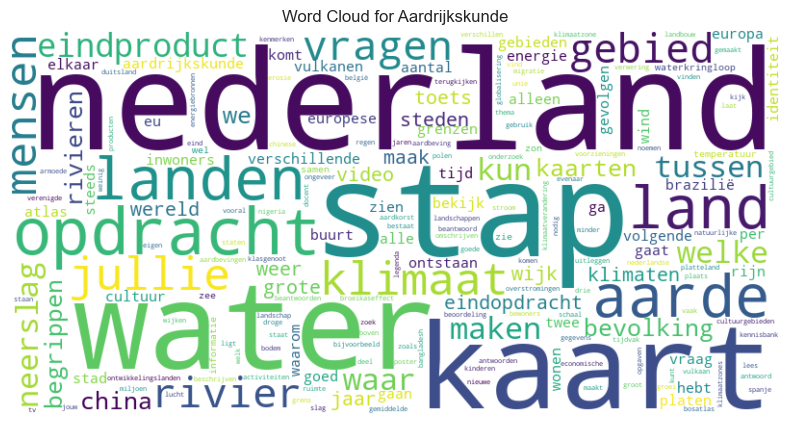

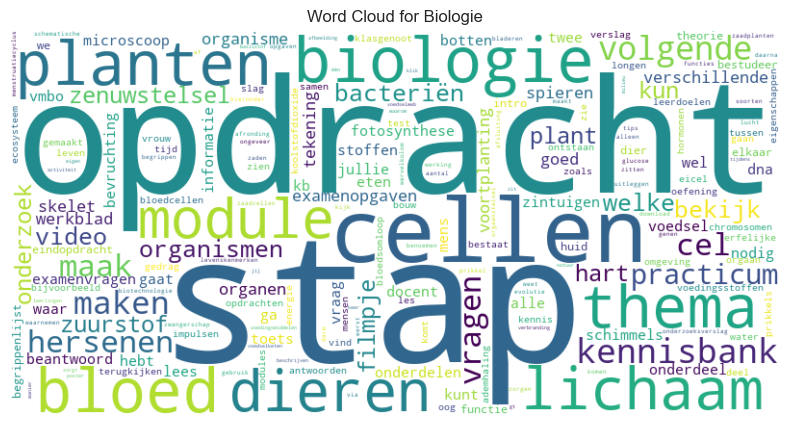

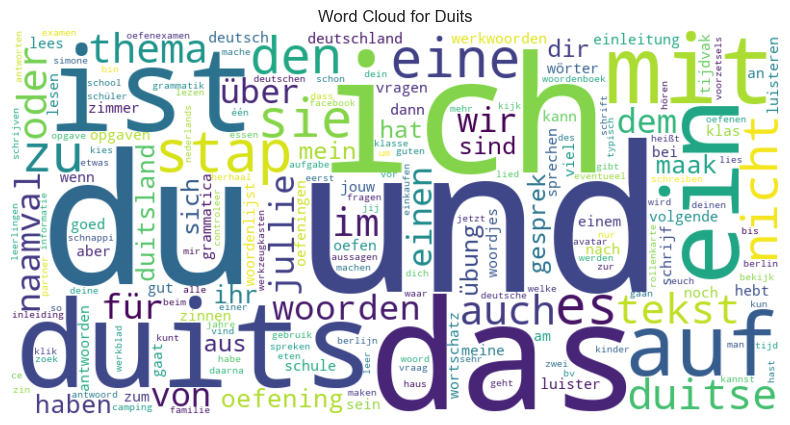

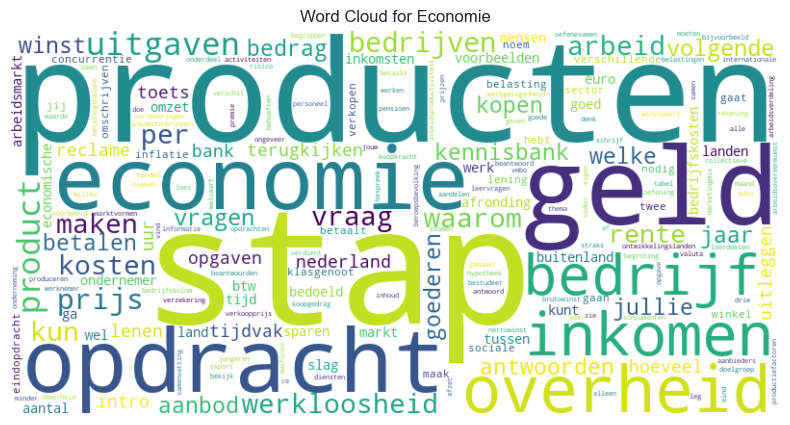

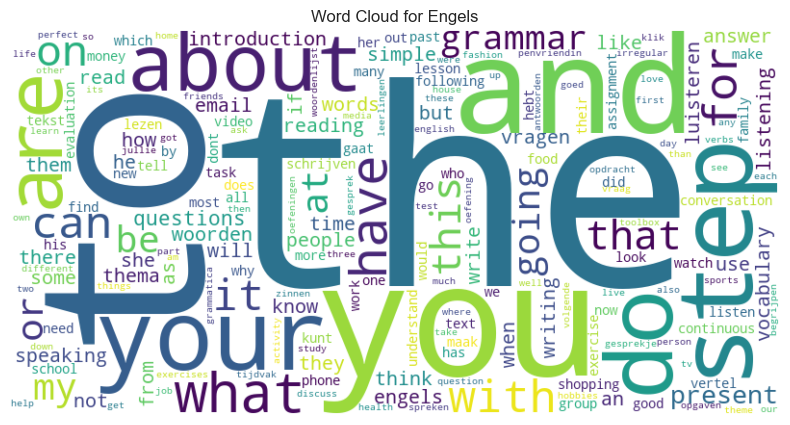

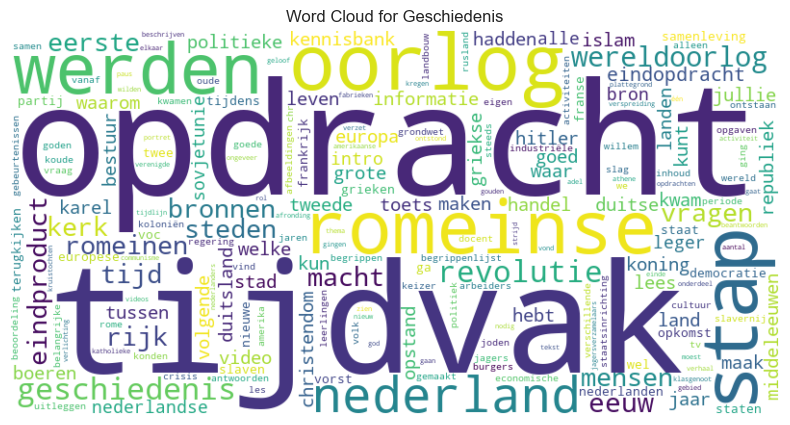

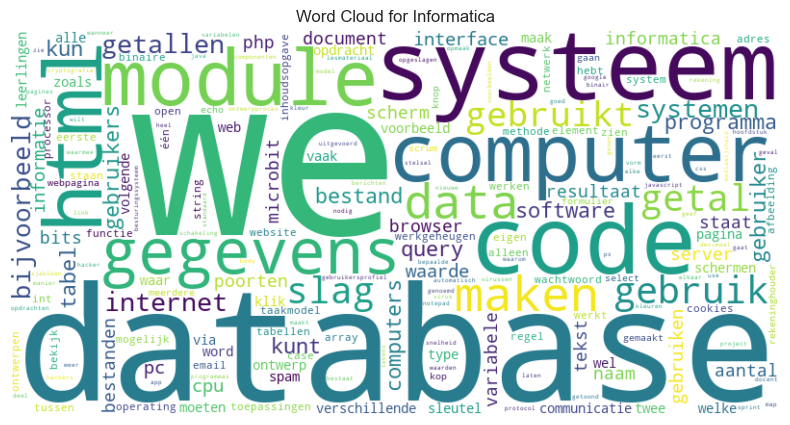

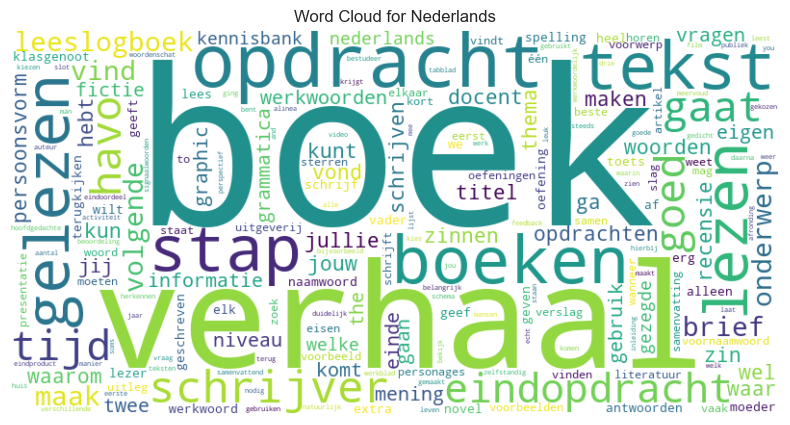

Geen data voor Rekenen, Word Cloud niet gegenereerd.


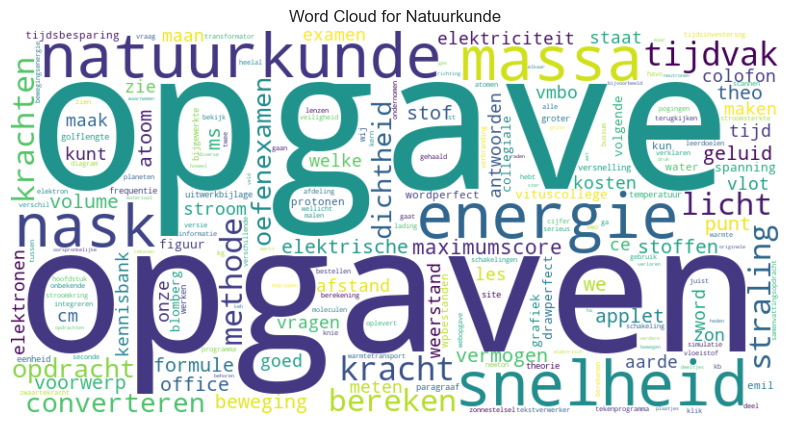

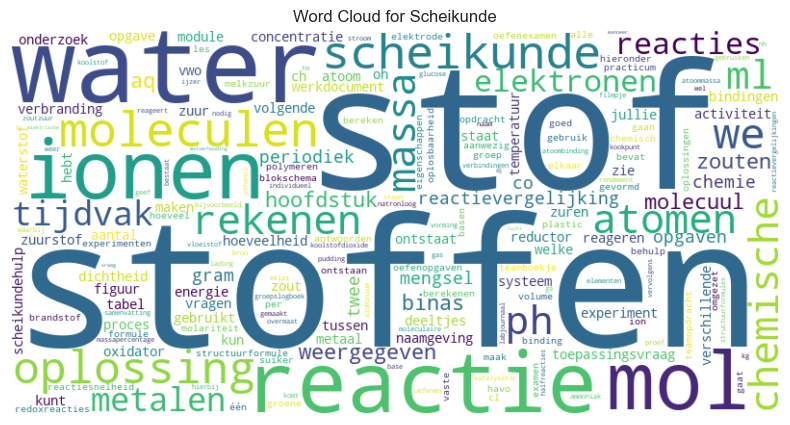

Geen data voor M&M, Word Cloud niet gegenereerd.
Geen data voor M&N, Word Cloud niet gegenereerd.
Geen data voor Maatschappij, Word Cloud niet gegenereerd.


In [33]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_wordclouds(tfidf_df, valid_subjects):
    for vak in valid_subjects:
        vak_df = tfidf_df[tfidf_df['vakken'] == vak].drop(columns='vakken')
        if not vak_df.empty and vak_df.sum().sum() != 0:  # Controleer of het vak data bevat
            mean_tfidf = vak_df.mean(axis=0)
            wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(mean_tfidf)
            plt.figure(figsize=(10, 5))
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.title(f'Word Cloud for {vak}')
            plt.axis('off')
            plt.show()
        else:
            print(f"Geen data voor {vak}, Word Cloud niet gegenereerd.")

plot_wordclouds(tfidf_df, valid_subjects)


In [34]:
import pandas as pd

# Functie om belangrijkste keywords te vinden per vak
def get_top_keywords_per_class(tfidf_df, valid_subjects, n=5):
    top_keywords = {}
    for vak in valid_subjects:
        # Filter rows belonging to the current subject
        vak_df = tfidf_df[tfidf_df['vakken'] == vak].drop(columns='vakken')
        if not vak_df.empty:
            # Calculate mean TF-IDF score per word for the current subject
            mean_tfidf = vak_df.mean(axis=0)
            top_keywords[vak] = mean_tfidf.sort_values(ascending=False).head(n).index.tolist()
        else:
            top_keywords[vak] = []
    return top_keywords

top_keywords_per_vak = get_top_keywords_per_class(tfidf_df, valid_subjects, n=4)

# Creëer een DataFrame voor de weergave van de resultaten
results_df = pd.DataFrame.from_dict(top_keywords_per_vak, orient='index', columns=[f'keyword_{i+1}' for i in range(4)])
print(results_df)


                keyword_1  keyword_2 keyword_3 keyword_4
Aardrijkskunde  nederland       stap     water     kaart
Biologie             stap   opdracht    cellen  biologie
Duits                 und         du       ich       das
Economie             stap  producten      geld  opdracht
Engels                the         to       you       and
Geschiedenis     opdracht    tijdvak    oorlog      stap
Informatica            we   database   systeem      code
Nederlands           boek    verhaal  opdracht     tekst
Rekenen              None       None      None      None
Natuurkunde        opgave    opgaven   energie  snelheid
Scheikunde        stoffen       stof     water   reactie
M&M                  None       None      None      None
M&N                  None       None      None      None
Maatschappij         None       None      None      None


In [35]:
dataframe

text          vakken  \
5      Geslachtziekten Kennisbank Bestudeer uit de Ke...        Biologie   
6      SOA Verwerking Stap7 Soa's Bekijk dit filmpje:...        Biologie   
8      Fotosynthese Intro Mensen moeten ademhalen om ...        Biologie   
9      NL transportland Vooraf Nederland is een klein...  Aardrijkskunde   
13     Hoofdstuk 3: Grenzen en identiteit Inleiding G...  Aardrijkskunde   
...                                                  ...             ...   
64381  Nederland waterland Vooraf In het begin van de...  Aardrijkskunde   
64382  Problemen met water Vooraf Aan een aantal wete...  Aardrijkskunde   
64384  De wereld na de oorlog 1. Het einde van de wer...    Geschiedenis   
64387  Cellen en weefsels Kennisbank Alle organismen ...        Biologie   
64396  START test Thema Grenzen en identiteit Inleidi...  Aardrijkskunde   

      leerjaren                                            niveaus  \
5             4  4, VMBO gemengde leerweg, VMBO kaderberoepsger...   
6             4                                             HAVO 4   
8          1, 2  1, 2, VMBO gemengde leerweg, VMBO kaderberoeps...   
9             3                                      HAVO 3, VWO 3   
13         3, 4  3, 4, VMBO gemengde leerweg, VMBO kaderberoeps...   
...         ...                                                ...   
64381      1, 2                       HAVO 1, HAVO 2, VWO 1, VWO 2   
64382      1, 2                       HAVO 1, HAVO 2, VWO 1, VWO 2   
64384         3                                             HAVO 3   
64387      3, 4            3, 4, VMBO basisberoepsgerichte leerweg   
64396      3, 4  3, 4, VMBO gemengde leerweg, VMBO kaderberoeps...   

       cleaned_vakken leerjaren_split  \
5            Biologie             [4]   
6            Biologie             [4]   
8            Biologie          [1, 2]   
9      Aardrijkskunde             [3]   
13     Aardrijkskunde          [3, 4]   
...               ...             ...   
64381  Aardrijkskunde          [1, 2]   
64382  Aardrijkskunde          [1, 2]   
64384    Geschiedenis             [3]   
64387        Biologie          [3, 4]   
64396  Aardrijkskunde          [3, 4]   

                                           niveaus_split  \
5      [4, VMBO gemengde leerweg, VMBO kaderberoepsge...   
6                                               [HAVO 4]   
8      [1, 2, VMBO gemengde leerweg, VMBO kaderberoep...   
9                                        [HAVO 3, VWO 3]   
13     [3, 4, VMBO gemengde leerweg, VMBO kaderberoep...   
...                                                  ...   
64381                     [HAVO 1, HAVO 2, VWO 1, VWO 2]   
64382                     [HAVO 1, HAVO 2, VWO 1, VWO 2]   
64384                                           [HAVO 3]   
64387          [3, 4, VMBO basisberoepsgerichte leerweg]   
64396  [3, 4, VMBO gemengde leerweg, VMBO kaderberoep...   

                                          processed_text  
5      geslachtziekten kennisbank bestudeer kennisban...  
6      soa verwerking stap soas bekijk filmpje soas e...  
8      fotosynthese intro mensen moeten ademhalen hel...  
9      nl transportland vooraf nederland klein land g...  
13     hoofdstuk grenzen identiteit inleiding grenzen...  
...                                                  ...  
64381  nederland waterland vooraf begin e eeuw kreeg ...  
64382  problemen water vooraf aantal wetenschappers g...  
64384  wereld oorlog einde wereldrijken koude oorlog ...  
64387  cellen weefsels kennisbank alle organismen bes...  
64396  start test thema grenzen identiteit inleiding ...  

[12270 rows x 8 columns]

In [36]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

X = dataframe['processed_text']
y_leerjaren = dataframe['leerjaren']
y_niveaus = dataframe['niveaus']
y_vakken = dataframe['vakken']

X_train, X_test, y_train_leerjaren, y_test_leerjaren = train_test_split(X, y_leerjaren, test_size=0.2, random_state=42)
_, _, y_train_niveaus, y_test_niveaus = train_test_split(X, y_niveaus, test_size=0.2, random_state=42)
_, _, y_train_vakken, y_test_vakken = train_test_split(X, y_vakken, test_size=0.2, random_state=42)

# Tokenizer
max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

# Label Encoding
le_leerjaren = LabelEncoder()
y_leerjaren_combined = pd.concat([y_train_leerjaren, y_test_leerjaren])
le_leerjaren.fit(y_leerjaren_combined)
y_train_leerjaren_enc = le_leerjaren.transform(y_train_leerjaren)
y_test_leerjaren_enc = le_leerjaren.transform(y_test_leerjaren)

le_niveaus = LabelEncoder()
y_niveaus_combined = pd.concat([y_train_niveaus, y_test_niveaus])
le_niveaus.fit(y_niveaus_combined)
y_train_niveaus_enc = le_niveaus.transform(y_train_niveaus)
y_test_niveaus_enc = le_niveaus.transform(y_test_niveaus)

le_vakken = LabelEncoder()
y_vakken_combined = pd.concat([y_train_vakken, y_test_vakken])
le_vakken.fit(y_vakken_combined)
y_train_vakken_enc = le_vakken.transform(y_train_vakken)
y_test_vakken_enc = le_vakken.transform(y_test_vakken)


In [37]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
import numpy as np


In [38]:
# Input layer
input_text = Input(shape=(max_len,))

# Embedding layer
embedding = Embedding(input_dim=max_words, output_dim=128, input_length=max_len)(input_text)

# LSTM layer
lstm = LSTM(64, return_sequences=True)(embedding)
lstm = LSTM(64)(lstm)
lstm = Dropout(0.5)(lstm)

# Output layers for each label
output_leerjaren = Dense(len(le_leerjaren.classes_), activation='softmax', name='leerjaren')(lstm)
output_niveaus = Dense(len(le_niveaus.classes_), activation='softmax', name='niveaus')(lstm)
output_vakken = Dense(len(le_vakken.classes_), activation='softmax', name='vakken')(lstm)

# Combine into a model
model = Model(inputs=input_text, outputs=[output_leerjaren, output_niveaus, output_vakken])


C:\Users\jesse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [39]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss={'leerjaren': 'sparse_categorical_crossentropy',
                    'niveaus': 'sparse_categorical_crossentropy',
                    'vakken': 'sparse_categorical_crossentropy'},
              metrics={'leerjaren': 'accuracy',
                       'niveaus': 'accuracy',
                       'vakken': 'accuracy'})


In [40]:
history = model.fit(X_train_pad, 
                    {'leerjaren': y_train_leerjaren_enc, 
                     'niveaus': y_train_niveaus_enc, 
                     'vakken': y_train_vakken_enc},
                    epochs=10,  # Adjust the number of epochs as needed
                    batch_size=32,
                    validation_data=(X_test_pad, 
                                     {'leerjaren': y_test_leerjaren_enc, 
                                      'niveaus': y_test_niveaus_enc, 
                                      'vakken': y_test_vakken_enc}))


Epoch 1/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - leerjaren_accuracy: 0.1405 - loss: 10.2811 - niveaus_accuracy: 0.0697 - vakken_accuracy: 0.1856 - val_leerjaren_accuracy: 0.2555 - val_loss: 7.9036 - val_niveaus_accuracy: 0.1630 - val_vakken_accuracy: 0.4613
Epoch 2/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - leerjaren_accuracy: 0.2683 - loss: 7.7239 - niveaus_accuracy: 0.1926 - vakken_accuracy: 0.4663 - val_leerjaren_accuracy: 0.3830 - val_loss: 6.7760 - val_niveaus_accuracy: 0.2408 - val_vakken_accuracy: 0.5844
Epoch 3/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 14s 44ms/step - leerjaren_accuracy: 0.3831 - loss: 6.5479 - niveaus_accuracy: 0.2635 - vakken_accuracy: 0.5920 - val_leerjaren_accuracy: 0.4621 - val_loss: 6.0929 - val_niveaus_accuracy: 0.3215 - val_vakken_accuracy: 0.6239
Epoch 4/10
307/307 ━━━━━━━━━━━━━━━━━━━━ 13s 44ms/step - leerjaren_accuracy: 0.4787 - loss: 5.6354 - niveaus_accuracy: 0.3290 - vakken_accuracy: 0.6740 - val_leerjaren_accuracy: 0.4894 - val_loss: 5.4645 - va

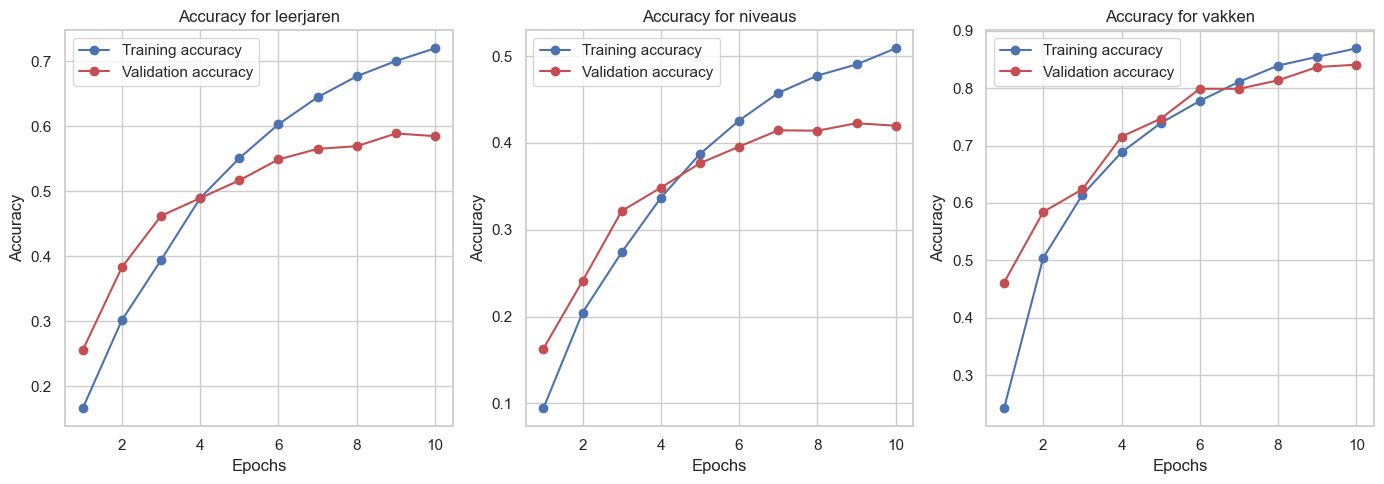

In [41]:
import matplotlib.pyplot as plt

# Extract accuracy history for each output
leerjaren_acc = history.history['leerjaren_accuracy']
niveaus_acc = history.history['niveaus_accuracy']
vakken_acc = history.history['vakken_accuracy']

# Extract validation accuracy history for each output
val_leerjaren_acc = history.history['val_leerjaren_accuracy']
val_niveaus_acc = history.history['val_niveaus_accuracy']
val_vakken_acc = history.history['val_vakken_accuracy']

# Plotting the accuracies
epochs = range(1, len(leerjaren_acc) + 1)

plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
plt.plot(epochs, leerjaren_acc, 'bo-', label='Training accuracy')
plt.plot(epochs, val_leerjaren_acc, 'ro-', label='Validation accuracy')
plt.title('Accuracy for leerjaren')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs, niveaus_acc, 'bo-', label='Training accuracy')
plt.plot(epochs, val_niveaus_acc, 'ro-', label='Validation accuracy')
plt.title('Accuracy for niveaus')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs, vakken_acc, 'bo-', label='Training accuracy')
plt.plot(epochs, val_vakken_acc, 'ro-', label='Validation accuracy')
plt.title('Accuracy for vakken')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
